# Classifier Certification -- Munging and Feature Extraction

##### IPython Autotime Magic

In [1]:
# External extension that allows us to time each block automagically
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Installed autotime.py. To use it, type:
  %load_ext autotime


/Users/keenan.hawekotte/anaconda/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


## Imports

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
% matplotlib inline

import numpy as np
import pandas as pd
import imageio as io
import os, sys
import math
import cPickle

time: 1.2 s


## Data loading functions

In [3]:
def unpickle(file):
    """
    Function to load and unpickle a given file and return a dict
    """
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def get_data_and_labels(folder, as_img=True, get_meta=True):
    """
    Takes in a folder location and outputs the images.
    Can output the image either as a vector or reformatted as a normal RGB image.
    Can also output metadata of images.
    """
    all_data = []
    all_labels = []
    meta = None
    for file in os.listdir(folder):
        if get_meta and 'meta' in file:
            meta = unpickle(os.path.join(folder, file))
        if not 'data_batch' in file:
            continue
        folder_plus_file = os.path.join(folder, file)
        dict = unpickle(folder_plus_file)
        if as_img:
            images = [to_img(img) for img in dict['data']]
        else:
            images = dict['data']
        all_data.extend(images)
        all_labels.extend(dict['labels'])
    if get_meta:
        return all_data, all_labels, meta
    else:
        return all_data, all_labels

def to_img(data):
    """
    Translates the CIFAR-10 image vectors into RGB images
    """
    img_array = np.zeros((32, 32, 3), dtype='uint8')
    index = 0
    
    for i in range(3):
        for j in range(32):
            for k in range(32):
                img_array[j,k,i] = data[index]
                index += 1
    return img_array

time: 28.2 ms


## Get the data

#### Download the dataset (OPTIONAL)
##### Note: this downloads the folder to the current working directory of your IPython kernel

In [ ]:
import urllib, tarfile
_ = urllib.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")
with tarfile.open("cifar-10-python.tar.gz", "r:gz") as tf:
    tf.extract('cifar-10-batches-py')

#### Import the data

In [4]:
#EXAMPLE:  data, labels, meta = get_data_and_labels('/Users/keenan.hawekotte/Downloads/cifar-10-batches-py/', as_img=True, get_meta=True)
data, labels, meta = get_data_and_labels('FILE/PATH/HERE', as_img=True, get_meta=True)
# Note: Images are 32x32x3 where R = 0, G = 1, B = 2

time: 35.1 s


#### Visualize an image

Ind: 8
Label: ship


/Users/keenan.hawekotte/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


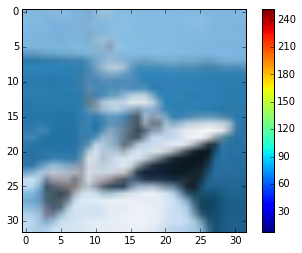

time: 293 ms


In [5]:
ind = 8  # Choose a random image to display

plt.imshow(data[ind])
plt.colorbar()
image = data[ind]

print 'Ind:', ind
print 'Label:', meta['label_names'][labels[ind]]

## Average color plotting

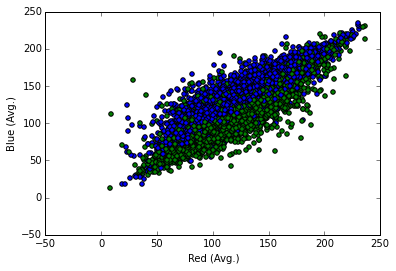

time: 28.3 s


In [6]:
# Plot Colors
fig = plt.figure()
ax = fig.add_subplot(111)
for ind, datum in enumerate(data):
    if meta['label_names'][labels[ind]] == 'ship':
        c = 'b'
    elif meta['label_names'][labels[ind]] == 'frog':
        c = 'g'
    else:
        continue
    tmp_image = datum
    red = np.average(tmp_image[:, :, 0])
    green = np.average(tmp_image[:, :, 1])
    blue = np.average(tmp_image[:, :, 2])
    # You can choose two of the following at any time to display: [hue, saturation, lightness]
    # Make sure you adjust the axes labels below accordingly
    ax.scatter(red, green, c=c)
ax.set_xlabel('Red (Avg.)')
ax.set_ylabel('Blue (Avg.)')

## Plotting for H/S/L

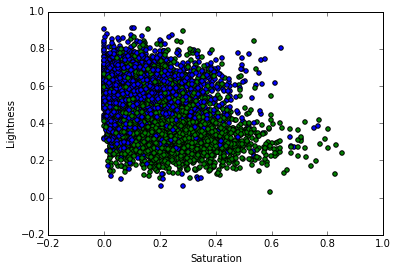

time: 32.3 s


In [7]:
# Plot HSL
fig = plt.figure()
ax = fig.add_subplot(111)
for ind, datum in enumerate(data):
    if meta['label_names'][labels[ind]] == 'ship':
        c = 'b'
    elif meta['label_names'][labels[ind]] == 'frog':
        c = 'g'
    else:
        continue
    tmp_image = datum
    red = tmp_image[:, :, 0]
    green = tmp_image[:, :, 1]
    blue = tmp_image[:, :, 2]
    hue = np.average(np.arctan2(((3)**(1/2)/2.) * (green - blue), 2*red - green - blue))
    lightness = np.average(0.5 * (np.min([np.average(red), np.average(green), np.average(blue)]) + 
                                  np.max([np.average(red), np.average(green), np.average(blue)]))) / 255.
    C = float(np.max([np.average(red), np.average(green), np.average(blue)]) - 
              np.min([np.average(red), np.average(green), np.average(blue)]))
    saturation = 0 if C==0 else C / (1 - np.abs(2*lightness - 1.)) / 255.
    # You can choose two of the following at any time to display: [hue, saturation, lightness]
    # Make sure you adjust the axes labels below accordingly
    ax.scatter(saturation, lightness, c=c)
ax.set_xlabel('Saturation')
ax.set_ylabel('Lightness')

## Color Histograms

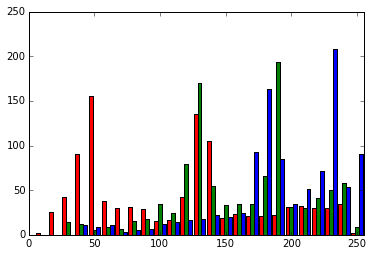

time: 269 ms


In [8]:
# Bins by 10 to 255
colors = [None, None, None]
bins = np.array(range(0, 255, 10)) # left inclusive, right non-inclusive
for color in xrange(image.shape[2]):
    counts = np.zeros(len(bins))
    for pixel in image[:, :, color].flatten():
        locs = np.where(bins - pixel >= 0)[0]
        if len(locs) == 0:
            counts[-1] += 1
        else:
            counts[min(locs)] += 1
    colors[color] = counts
colors = np.array(colors)

ax = plt.subplot(111)
offset = 3
ax.bar(bins - offset, colors[0], width=offset, color='r', align='center')
ax.bar(bins, colors[1], width=offset, color='g', align='center')
ax.bar(bins + offset, colors[2], width=offset, color='b', align='center')
ax.set_xlim(0, 255)
plt.show()

## Image Normalization

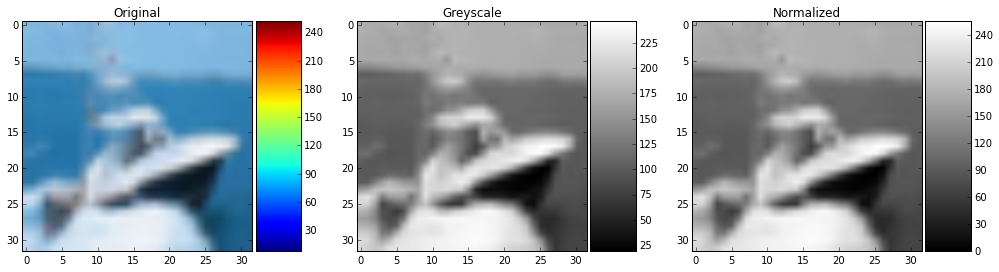

time: 652 ms


In [9]:
# Image Normalization
greyscale = np.dot(image[...,:3], [0.299, 0.587, 0.114])
wanted_range = [0, 255]
image_range = [np.min(greyscale.flatten()), np.max(greyscale.flatten())]
norm_im = (greyscale - image_range[0]) * (wanted_range[1] - wanted_range[0]) / (image_range[1] - image_range[0]) + wanted_range[0]

# Plooooooot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 9))
axes[0].set_title('Original')
im1 = axes[0].imshow(image)
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="20%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

axes[1].set_title('Greyscale')
im2 = axes[1].imshow(greyscale, cmap=plt.cm.gray)
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="20%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

axes[2].set_title('Normalized')
im3 = axes[2].imshow(norm_im, cmap=plt.cm.gray)
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="20%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

## Histogram Equalization

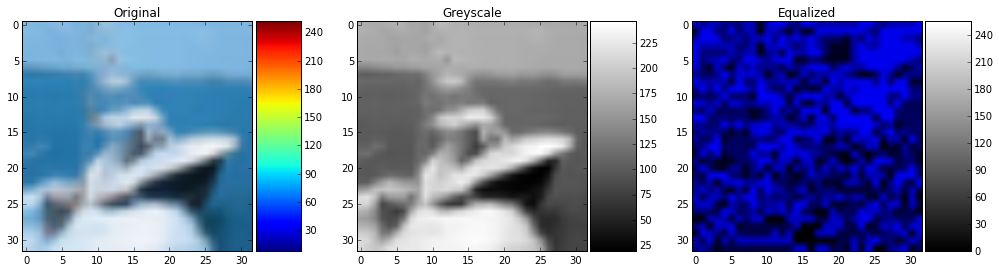

time: 698 ms


In [10]:
# Histogram equalization
num_colors = 256
bins = range(num_colors)
eq_im = np.zeros(image.shape)
counts = np.zeros(len(bins))
for pixel in np.dot(image[...,:3], [0.299, 0.587, 0.114]).flatten():
    locs = np.where(bins - pixel >= 0)[0]
    if len(locs) == 0:
        counts[-1] += 1
    else:
        counts[min(locs)] += 1
counts = np.array(counts) / float(np.max(counts))
cdf = np.array([x if ind == 0 else x + np.sum(counts[:ind]) for ind, x in enumerate(counts)])
norm_cdf = 255. * cdf / cdf[-1]
eq_im[:, :, color] = np.interp(image[:, :, color].flatten(), bins[:-1], norm_cdf[:-1]).reshape(image[:, :, color].shape)

# Plooooooot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 9))
axes[0].set_title('Original')
im1 = axes[0].imshow(image)
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="20%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

axes[1].set_title('Greyscale')
im2 = axes[1].imshow(greyscale, cmap=plt.cm.gray)
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="20%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

axes[2].set_title('Equalized')
im3 = axes[2].imshow(eq_im, cmap=plt.cm.gray)
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="20%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

##### ^^ Not too effective for this, eh?

# Homework:
##### Submit to @have_uh_cot_ee or [keenan.hawekotte@hudl.com](keenan.hawekotte@hudl.com)

### 1) Boolean Features
Identify at least five non-color related boolean features that are related to the images and run them through a decision tree. Post your features and outputs.

### 2) Numerical Features
Identify (or utilize) three numerical features and run them through a model of your choice (*cough* kNN *cough*). The chosen features must not be all colors or HSV values. Post the features and outputs.

### 3) Color Gradient
Extend the color gradient to at least ten bins. Identify the bins and plot at least one image of the bins for a frog and one for a ship. Post bins and images.

### Bonus) 
Using whatever method you want, run an image through an HoG transform. Post the before and after.